**Student ID:** 2012149 and 1904805

---
## Assignment 3 Part II 

We begin by importing the libraries we will need to complete the assignment.

In [1]:
import numpy as np
from numpy import array
from numpy.linalg import solve
from scipy . special import ellipj
from scipy.linalg import expm, inv
import pandas as pd

from numpy import array, linspace, log, zeros, nan, eye
from numpy.linalg import norm, inv

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18}) # increase font size

**Problem Set-Up**

For question 2.1 and 2.2, we will test our implementation on both the *Backward Euler* and the *Midpoint* method using the 2x2 ODE: 

$$y'(t)=F(y(t)) \;\;\;\;\;\; y(0)=y_0 $$ with :
$$ F(y_1,y_2) = \left(\begin{array}{cc} y_2 \\[1ex] y_2(\lambda-2y_1) \end{array}\right) $$

Given $\lambda=1$ and initial conditions $y_0=(2, -2)^T$, this has the exact solution:

$$ Y(t) = \left(\begin{array}{cc}
   \frac{2e^t}{2e^t-1} \\[2ex]
    \frac{-2e^{t}}{4e^{2t}-4e^t+1}
 \end{array}\right) $$
 
 We will solve this on the interval $[0,T]$, where in this particular exercise $T=1$.
 
 Coding wise, we begin by defining the function f, its jacobian Df, and the exact solution Y.

In [2]:
T = 1

def f(t,y): # Function f 
    return array([y[1], y[1]*(1-2*y[0])])

def Df(t,y): # Jacobian of the function f 
    return array([[0,1],[2*y[1],1-2*y[0]]])

def Y(t):    # Exact solution
    return np.array([2*np.exp(t)/(2*np.exp(t)-1),-2*np.exp(t)/(4*np.exp(2*t)-4*np.exp(t)+1)])

We now import the five methods used in quiz 1 and 2, which are *npPrint*, *evolve*, *computeEocs*, *newton*, and *backwardEuler*. 

In [3]:
# The defintions from quiz 3

def newton(F,DF,x0,eps,K):
    k  = 0
    x  = x0.copy().astype(np.float64)  # note: with x=x0 changes to x also changes to x0 with numpy arrays
    Fx = F(x)
    while Fx.dot(Fx) > eps*eps and k<K:
        x[:] -= solve(DF(x), Fx)  # don't construct a new vector in each step - they could be large
        Fx = F(x)
        k += 1
    return x,k

def dirk(f,Df, t0,y0, h, alpha,beta,gamma):
    m = len(y0)
    s = len(gamma)
    y = y0.copy().astype(float)
    k = np.zeros([s,m])
    for i in range(s):
        ti = t0+alpha[i]*h
        yi = y0.copy().astype(float)
        for j in range(i):
            yi += h*beta[i,j]*k[j]
        k[i,:] = f(ti,yi);        
        if beta[i,i] > 0:
            k[i,:],K = newton (lambda k: k-f(ti,yi+h*beta[i,i]*k),
                             lambda k: np.eye(m)-h*beta[i,i]*Df(ti,yi+h*beta[i,i]*k),
                             k[i,:], 1e-15, 1000)
            assert K < 1000        
        y += h*gamma[i]*k[i,:]
    return y
        
def backwardEuler( f,Df, t0,y0, h):
    # not good style but reduces polution of the global namespace when running the tests
    from numpy import eye
    F =  lambda delta: delta-f(t0+h,y0+h*delta)
    DF = lambda delta: eye(len(y0))-h*Df(t0+h,y0+h*delta)
    delta,_ = newton(F,DF,f(t0+h,y0),h*h*1e-5,1000)
    return y0+h*delta

def evolve(phi,f,Df,t0,y0,T,N):
    h = T/N
    y = np.zeros([N+1, len(y0)])
    y[0] = y0
    t = 0
    for i in range(N):
        y[i+1] = phi(f,Df,t,y[i],h)
        t = t+h
    return y

def computeEocs( herr ): 
    eocs = np.zeros(len(herr)-1)
    for i in range(len(eocs)):
        eocs [i] = np.log(herr[i+1][1]/herr[i][1])/np.log(herr[i+1][0]/herr[i][0])
    return eocs

def npPrint(a, f={'float_kind':lambda x: "%.5e" % x}): 
   print( np.array2string(a, formatter=f) )

We are going to compute errors at the final time t and the EOC for the sequence of time steps given by $ h_{i}= \frac{1}{N_{i}} $ with $ N_{i} = N_{0} * 2^{i} $ for $i \in {(0,...,10)}$ and $N_{0} = 20$ . 

To avoid code duplication, we implement a function *experiment* to perform the computation of the errors for the given time steps and the eocs. The method returns an array of length 11, with each entry of the form ‘[h,error,eoc]’.

In [4]:
def experiment(stepper): 
    M =11
    herr = np.zeros((M,3)) 
    for m in range(M):
        N = 20*2**m
        h = 1/N
        y = evolve(stepper, f,Df, 0,Y(0),T, N)
        herr[m][0] = h
        herr[m][1]= np.linalg.norm(y[-1]-Y(T))
    for i in range(10):
        herr[i+1][2]= computeEocs(herr)[i]
    return herr

# Question 2.1


We test our simulation using the Backward Euler Method. The Backward Euler Method has the following butcher table: $$ \begin{array}{l|l} 1&1 \\ \hline & 1 \end{array} $$



The table below has three columns, one for the time step h, one for the approximation error, and the final column showing the experimental order of convergence. 

In [5]:
aCN = np.array([1])
bCN = np.array([[1]])
gCN = np.array([1])

stepper = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,aCN,bCN,gCN)
resBE = experiment(stepper)



We test our simulation using the Midpoint Method. The Midpoint Method has the following butcher table: $$ \begin{array}{l|l} 1/2&1/2 \\ \hline & 1 \end{array} $$ 



The table below has three columns, one for the time step h, one for the approximation error, and the final column showing the experimental order of convergence. 

In [6]:
aCN = np.array([1/2])
bCN = np.array([[1/2]])
gCN = np.array([1])

stepper = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,aCN,bCN,gCN)
resMP = experiment(stepper)


We test our simulation using the third order Dirk method. This method has the following butcher table: $$ \begin{array}
{c|cccc}
\frac{1}{3} &\frac{1}{3} &0 \\
1& 1& 0& \\
\hline
& \frac{3}{4} &\frac{1}{4}
\end{array} $$



The table below has three columns, one for the time step h, one for the approximation error, and the final column showing the experimental order of convergence. 

In [7]:
aCN = np.array([1/3,1])
bCN = np.array([[1/3,0],[1,0]])
gCN = np.array([3/4,1/4])

stepper = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,aCN,bCN,gCN)
resDI = experiment(stepper)

In [8]:
res = np.hstack([resBE,resMP,resDI])

# columns of table
columns=['h', 'BE-error', 'BE-eoc', 'Midpoint-error','Midpoint-eoc','Dirk-error','Dirk-eoc']
# values in table
keys = {columns[0]: resBE[:,0], columns[1]: resBE[:,1], columns[2]: resBE[:,2],
                                columns[3]: resMP[:,1], columns[4]: resMP[:,2],
                                columns[5]: resDI[:,1], columns[6]: resDI[:,2]}
# generate table
table = pd.DataFrame(keys, index=range(res.shape[0]),
        columns=columns)
# format floating points for each column
table = table.style.format({columns[0]:'{:.4e}',
                            columns[1]:'{:.6e}', columns[3]:'{:.6e}', columns[5]:'{:.6e}',
                            columns[2]:'{:.3f}', columns[4]:'{:.3f}', columns[6]:'{:.3f}' })
# print(table.to_latex()) # output result as latex table for inclusion in tex document
table

,h,BE-error,BE-eoc,Midpoint-error,Midpoint-eoc,Dirk-error,Dirk-eoc
0,5.0000e-02,3.471436e-02,0.000,5.731942e-04,0.000,1.238511e-05,0.000
1,2.5000e-02,1.749564e-02,0.989,1.431922e-04,2.001,1.518548e-06,3.028
2,1.2500e-02,8.783413e-03,0.994,3.579141e-05,2.000,1.879150e-07,3.015
3,6.2500e-03,4.400738e-03,0.997,8.947439e-06,2.000,2.336896e-08,3.007
4,3.1250e-03,2.202644e-03,0.999,2.236834e-06,2.000,2.913552e-09,3.004
5,1.5625e-03,1.101893e-03,0.999,5.592068e-07,2.000,3.637213e-10,3.002
6,7.8125e-04,5.510896e-04,1.000,1.398016e-07,2.000,4.543700e-11,3.001
7,3.9063e-04,2.755806e-04,1.000,3.495040e-08,2.000,5.682848e-12,2.999
8,1.9531e-04,1.377993e-04,1.000,8.737601e-09,2.000,7.055788e-13,3.010
9,9.7656e-05,6.890187e-05,1.000,2.184398e-09,2.000,8.682292e-14,3.023


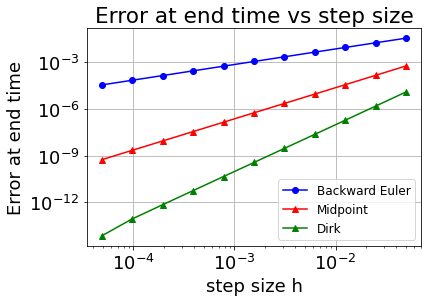

In [9]:
from matplotlib import pyplot as plt
plt.loglog(res[:,0],res[:,1],'bo-',label="Backward Euler")
plt.loglog(res[:,0],res[:,4],'r^-',label="Midpoint")
plt.loglog(res[:,0],res[:,7],'g^-',label="Dirk")
plt.legend(loc=4, prop={'size': 12})
plt.grid(True)
plt.title("Error at end time vs step size")
plt.xlabel("step size h")
plt.ylabel("Error at end time")
plt.show()

# Question 2.2 and Question 2.3

**Problem Setup:**
We consider the Hamiltonian given by:
$$ H(x,p) = \frac{1}{2}\Big(p^2+(k^2+1)x^2\Big) - \frac{1}{2}k^2x^4 $$ 
leading to the Hamiltonian system: $$ x' = p~,\qquad p' = -(k^2+1)x + 2k^2x^3~. $$
We can write this as: $$ y' = My + F(y) $$ with $y=(x,p)$ and
$$ M = \left(\begin{array}{cc} 0 & 1 \\ -(1+k^2) & 0 \end{array}\right)~,\qquad
   F(y) = \left(\begin{array}{c} 0 \\ 2k^2y_1 \end{array}\right) $$
The exact solution to the problem can be expressed using the _Jacobi elliptic
function_ $s_n,c_n,d_n$:
$$ x(t) = s_n(t,k^2)~,\qquad p(t) = x'(t) = c_n(t,k^2)d_n(t,k^2)~. $$

**Note:** This last function has been imported through scipy.special. 

We create a function *model* to modelize the problem: 

In [10]:
T=200

def model(k):
    # the model
    H  = lambda x,p: 0.5*(p*p+(k*k+1)*x*x) - k*k/2*x**4
    M  = array([ [0,1], [-(1.+k*k),0] ])
    F  = lambda y: array( [0, 2*k*k*y[0]**3] )
    DF = lambda y: array([ [0,0],
                           [2*k*k*3.*y[0]**2,0] ])
    # the exact solution
    def Y(t):
        sn,cn,dn,_ = ellipj(t,k*k)
        return array([ sn, cn*dn ])
    return H,M,F,DF,Y

Throughout this exercise, we will consider three Dirk methods given by the butcher table: 

\begin{array}
{c|cccc}
d & d &0 \\
1-d & 1-2d & d& \\
\hline
& \frac{1}{2} &\frac{1}{2}
\end{array} 

with $d = 0,\frac{1}{4},\frac{1}{2}+\frac{\sqrt{3}}{6}$

To avoid code duplication, we define a function *getbutcher* which returns in function of *d* the butcher tables of one of these Dirk methods.

In [11]:
def getbutcher(d):
    an = np.array([d,1-d])
    bn = np.array([[d,0],[1-2*d,d]])
    gn = np.array([0.5,0.5])
    return an, bn, gn

Next, we redefine the Dirk method, but this time with a tolerance of 1e-8 in the Newton method. This is to ensure it is sufficient for these experiments.

In [12]:
def dirk(f,Df, t0,y0, h, alpha,beta,gamma):
    m = len(y0)
    s = len(gamma)
    y = y0.copy().astype(float)
    k = np.zeros([s,m])
    for i in range(s):
        ti = t0+alpha[i]*h
        yi = y0.copy().astype(float)
        for j in range(i):
            yi += h*beta[i,j]*k[j]
        k[i,:] = f(ti,yi);        
        if beta[i,i] > 0:
            k[i,:],K = newton (lambda k: k-f(ti,yi+h*beta[i,i]*k),
                             lambda k: np.eye(m)-h*beta[i,i]*Df(ti,yi+h*beta[i,i]*k),
                             k[i,:], 1e-8, 1000)
            assert K < 1000        
        y += h*gamma[i]*k[i,:]
    return y

We then define the exponentially fit version of the multi-stage Dirk method. 

def eDirk(f,Df,t0,y0,h,alpha,beta,gamma,exphMs,exphMsInv,exphM): 
    m = len(y0)
    s = len(gamma)
    y = y0.copy().astype(float)
    k = np.zeros([s,m])
    for i in range(s):
        ti = t0+alpha[i]*h
        yi = y0.copy().astype(float)
        for j in range(i):
            yi += h*beta[i,j]*k[j]
        k[i,:] = f(ti,exphMs[i]*yi);        
        if beta[i,i] > 0:
            k[i,:],K = newton (lambda k: k-exphMsInv[i].dot(f(ti,exphMs[i]*(yi+h*beta[i,i]*k))),
                             lambda k: np.eye(m)-h*beta[i,i]*Df(ti,yi+exphMs[i]*h*beta[i,i]*k),
                             k[i,:], 1e-8, 1000)
            assert K < 1000        
        y += h*gamma[i]*k[i,:]
    return exphM.dot(y)

In [14]:
def eDirk(f,Df,t0,y0,h,alpha,beta,gamma,exphMs,exphMsInv,exphM): 
    m = len(alpha)
    r = len(y0)
    yi = exphMs.dot(y0)
    ks = np.zeros((m,r))
    for i in range(m):
        total = 0
        for j in range(i):
            total += beta[i,j]*ks[j]
        F = lambda delta: delta - exphMsInv.dot(f(t0 + (alpha[i]*h), exphMs.dot(y0+(h*total + beta[i,i]*delta))))
        DF = lambda delta: np.identity(r) - (h*Df(t0 + (alpha[i]*h), exphMs.dot(y0+(h*total + beta[i,i]*delta))))
        
        k, iterations = newton(F, Df, y0, 1e-15, 10**5)
        ks[i] = k
    s=0
    for i in range(len(ks)):
        s += gamma[i]*ks[i]
    y = exphM.dot(y0 + (h*s))
    return y 

In this next section, we use the Dirk and Edirk methods to compute an approximation to the Hamiltonian system. To see how efficient these methods are, we are going to compute the maximal error between initial time t=0 and final time t=200 and the EOC for the sequence of time steps given by $ h_{i}= \frac{1}{N_{i}} $ with $ N_{i} = N_{0} * 2^{i} $ for $i \in {(0,...,9)}$ and $N_{0} = 100$ . 

We setup a function *simulate* to solve the problem. 

**Parameters are:**

| Parameter | Type  | Description |
| --------- | ----  | ------------------------------------------------------- |
| k         | float | $k$ used in the model |
| T         | float | end time for simulation |
| d         | float | diagonal entry for DIRK method (used for all diagonal entries in $\beta$) |
| N         | int   | number of time steps to use ($h=\frac{T}{N}$). |
| useExp    | bool  | if _True_ use the exponentially fit RK method |

The *simulate* method returns the approximative solution to the hamiltonian system using the Dirk or Edirk method (conditional on useExp) and the maximal error  between intial time t=0 and final time t=200 for a given step size (CHECK IF N IS REALLY STEPSIZE). 

In [ ]:
def simulate(k,T, d, N, useExp):
    h = T/N
    # we really want to reach the final time, i.e., $y_N\approx Y(t_N)$
    assert h*N == T

    # the model (we don't need 'H' here) and initial condition
    _,M,F,DF,Y = model(k)
    y0 = Y(0)
    alpha,beta,gamma = getbutcher(d)
    if not useExp:
        stepper = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,alpha,beta,gamma)
        # setup the actual right hand side and Jacobian: f(t,y) = My + F(y)
        def f(t,y): # Function f 
            return M.dot(y)+F(y)
        def Df(t,y): # Jacobian of the function f 
            return M+DF(y)
    else: 
         # precompute required matrix exponentials
        exphM     = expm(M*h)
        for i in range (len(alpha)):
            exphMs = expm(alpha[i]*M*h)
            exphMsInv = inv(exphMs)
        stepper = lambda f,Df,t0,y0,h: eDirk(f,Df, t0,y0, h, alpha,beta,gamma, exphMs, exphMsInv, exphM)
        # setup the actual right hand side and Jacobian: f(t,y) = F(y)
        def f(t,y): 
            return F(y)
        def Df(t,y):
            return DF(y)
    t = np.linspace(0,T,N+1)
        
    try: # want to catch NaN indicating stability issues and also errors in Newton
        y = evolve(stepper, f,Df, 0,Y(0),T, N)
        # comput the maximum norm over time
        exact = Y(t).transpose() # contains (t_n,Y(t_n))_n
        error = max( np.linalg.norm( y-exact, axis=1) )
        # Approximations that are e.g. 100% off make the graphs hard to read and
        # we simply will ignore those simulations (we'll call that 'unstable').
        #if error/max(np.linalg.norm(exact, axis=1) ) > 1:
            #y,error = [], nan # error='nan' indicates failure
    except ValueError: # method not stable for given 'h'
        print(N,T/N,"failed: some NaN value produced!")
        y,error = [], nan # return 'not a number' for the error
    except AssertionError: # assert in dirk was triggered (failed Newton)
        print(N,T/N,"failed: Newton in dirk function failed!")
        y,error = [], nan # return 'not a number' for the error
    return y, error

Given the *simulate* method only produces results for a given stepsize and does not calculate Eocs, we must implement a second method *experiment2* to obtain the results for all of the other sequence of time steps.

In [ ]:
def experiment2(k,d,useExp): 
    M =10
    herr = np.zeros((M,3)) 
    for m in range(M):
        N = 100*2**m
        h = 1/N
        y , error = simulate(k,T,d,N,useExp)
        herr[m][0] = h
        herr[m][1]= error
    for i in range(9):
        herr[i+1][2]= computeEocs(herr)[i]
    return herr

To avoid code duplication and to produce an elegant table for the results of each method, we implement the following *gen_table* method. Each table will have two columns for each value of k, one showing the maximum error and the other the Eoc for each stepsize.

In [ ]:
def gen_table(k,d,useExp): 
    resk0=experiment2(k,d[0],useExp)
    resk1=experiment2(k,d[1],useExp)
    resk2=experiment2(k,d[2],useExp)

    res = np.hstack([resk0,resk1,resk2])
    # columns of table
    columns=['h', 'DM1 - error', 'DM1 - eoc', 'DM2 - error','DM2 -eoc','DM3 - error','DM3 -eoc']
    # values in table
    keys = {columns[0]: resk0[:,0], columns[1]: resk0[:,1], columns[2]: resk0[:,2],
                                columns[3]: resk1[:,1], columns[4]: resk1[:,2],
                                columns[5]: resk2[:,1], columns[6]: resk2[:,2]}
    # generate table
    table = pd.DataFrame(keys, index=range(res.shape[0]),
    columns=columns)
    # format floating points for each column
    table = table.style.format({columns[0]:'{:.4e}',
                            columns[1]:'{:.6e}', columns[3]:'{:.6e}', columns[5]:'{:.6e}',
                            columns[2]:'{:.3f}', columns[4]:'{:.3f}', columns[6]:'{:.3f}' })
    return table 

Since we want to plot the maximum relative error $\big|\frac{H(y_n)-H(y_0)}{H(y_0)}\big|$ and phase portraits for each of the time steps, we implement a *plot* method. 

In [ ]:
def plot(k,T,d,useExp, y):
    N = len(y)-1
    H,_,_,_,Y = model(k)
    H0 = H(*Y(0)) # call H(Y(0)[0],Y(0)[1])
    exact = Y(T)
    t = linspace(0,T,len(y))
 
    fig, (ax_phase,ax_H) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    if useExp:
         fig.suptitle("Exp using k="+str(k)+", d="+str(d)+ ", and N="+str(N))
    else:
        fig.suptitle("Using k="+str(k)+", d="+str(d)+ ", and N="+str(N))

    ax_phase.plot(y[:,0],y[:,1],'g.-')
    # mark position of approximation at final time
    ax_phase.plot(y[-1,0],y[-1,1],'r*',markersize=24)
    # also show position of exact solution at final time
    ax_phase.plot(exact[0],exact[1],'y*',markersize=24)
    ax_phase.set_title("phase portrait")
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('p')

    ax_H.semilogy( t, abs( H(y[:,0],y[:,1]) - H0 ) / abs(H0) )
    ax_H.set_title("Relative error in Hamiltonian")
    ax_H.set_xlabel('time')
    ax_H.set_ylabel('|H(y(t))-H(y0)|/|H(y0)|')
    fig.savefig("phase-"+str(N)+"-"+str(k)+"-"+str(d)+("-exp" if useExp else "")+".pdf")

Finally, to plot both the phase portrait and the maximum relative error as a function of the timesteps for each Dirk method and its exponentially fit counterpart, we implement a method *compute*: 

In [ ]:
def compute(k):
    T = 200
    dValues   = [0, 0.25, 0.5+np.sqrt(3)/6]
    N0        = 100
    # use 10 if 12 takes too long on your machine (test code with 8 or so)
    steps     = 10
    for useExp in [False,True]:
        for i,d in enumerate(dValues):
            for s in range(steps):
                N = N0*2**s
                y,a = simulate( k,T, d,N, useExp )
                # plot phase portrait and H conservation for two steps.
                # Make sure no errors occured.
                if len(y)>0 and s in [2,8]:
                    plot(k,T,d,useExp, y)
    return 0

In [ ]:
def plotErrorEoc(k, errors):
    # one figure with all methods for fixed 'k'
    fig, (ax_err,ax_eoc) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for i,e in enumerate(errors):
            # plot error and eoc over number of time steps
            ax_err.loglog(e[0],e[1], label="method "+str(i), marker='h')
            ax_eoc.semilogx(e[0],e[2], label="method "+str(i), marker='h')
    fig.suptitle("Results with k="+str(k))
    ax_err.set_xlabel('Number of steps')
    ax_err.set_ylabel('Maximum error over time')
    ax_err.legend()
    ax_err.grid(True)
    ax_eoc.set_xlabel('Number of steps')
    ax_eoc.set_ylabel('EOC')
    ax_eoc.legend()
    ax_eoc.grid(True)
    fig.savefig("result"+str(k)+'.pdf')

**For each value, that is the method with butcher table given by d, we present our results as follows:**
- A table with results for all three Dirk methods
- A table for its exponentially fit counterpart methods
- A series of phase portraits and maximum relative plots for each of these methods (6 in total)

**For k=0:**

In [ ]:
k = np.array([0,0.3,0.7])
d = np.array([0,0.25,0.5+np.sqrt(3)/6])

gen_table(k[0],d,0)

**Observation:**

For its exponentially fit counterpart, we obtain: 


In [ ]:
gen_table(k[0],d,1)

**Observation:**

We now plot a series of phase portaits and maximum relative plots. 

In [ ]:
errors = compute(k[0])

**Observation:**
For the three dirk methods, the one with d=0.25 has the lowest relative error in Hamiltonian, and the other two methods are similar, with d=0 being worse with a lower amount of steps. 

In [ ]:
plotErrorEoc(0.0,errors)

**For k=0.3:**

In [ ]:
gen_table(k[1],d,0)

**Observation:**

In [ ]:
gen_table(k[1],d,1)

**Observation:**

In [ ]:
errors = compute(k[1])

In [ ]:
plotErrorEoc(0.3,errors)

**For k=0.7:**

In [ ]:
gen_table(k[2],d,0)

**Observation:**

In [ ]:
gen_table(k[2],d,1)

**Observation:**

In [ ]:
errors = compute(k[2])

In [ ]:
plotErrorEoc(0.7,errors)